In [2]:
# ================================
# 📦 Imports
# ================================
from langgraph.graph import StateGraph, END
from langchain_core.runnables import Runnable
from langchain_core.messages import HumanMessage
from langchain.schema import HumanMessage
from langchain_groq import ChatGroq
from typing import TypedDict, Dict, List
from IPython.display import Markdown, display, Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import load_dotenv

In [3]:
# ================================
# 🤖 Load LLM
# ================================
load_dotenv()
llm = ChatGroq(groq_api_key=os.getenv("GROQ_API_KEY"), model="llama-3.1-8b-instant", temperature=0)

In [4]:
# ================================
# 📊 Load Data
# ================================
features_df = pd.read_csv("./customer_features_long_format.csv")
scores_df = pd.read_csv("./customer_scores_long_format.csv")


In [5]:
def reshape_data():
    features_pivot = features_df.pivot(index="customer_id", columns="feature_name", values="feature_value")
    scores_pivot = scores_df.pivot(index="customer_id", columns="score_name", values="score_value")
    combined = pd.concat([features_pivot, scores_pivot], axis=1).reset_index()
    return combined


In [36]:
# ================================
# 📦 LangGraph State
# ================================
class State(TypedDict):
    customer_id: str
    customer_data: Dict[str, float]
    insights: str
    image_summaries: List[str]


In [37]:
# ================================
# 🧩 Node: Fetch Customer Data
# ================================
def fetch_customer_data(input: State) -> State:
    customer_id = input['customer_id']
    combined_df = reshape_data()
    row = combined_df[combined_df.customer_id == customer_id].to_dict(orient="records")[0]
    return {
        "customer_id": customer_id,
        "customer_data": row,
        "insights": "",
        "image_summaries": []
    }

In [38]:
# Node: Generate Insight from KPIs and SHAPs
class GenInsightNode(Runnable):
    def invoke(self, input: State, config=None) -> State:
        customer_data = input["customer_data"]
        customer_id = input["customer_id"]

        # Separate KPIs and SHAPs
        kpis = {k: v for k, v in customer_data.items() if k in ["rsrp", "sinr"]}
        shap_values = {k: v for k, v in customer_data.items() if k.startswith("shap_")}
        scores = {k: v for k, v in customer_data.items() if k in ["main_score", "signal_quality_subscore"]}

        prompt = f"""

                "Act as a Customer Experience Analyst, responsible for interpreting and communicating complex data insights to stakeholders. 
                Given the following KPI values, SHAP values, and scores for a customer with ID {customer_id}, 
                provide a natural language summary explaining why the customer's experience score is the way it is. 
                Assume you have expertise in data analysis and customer experience metrics. 
                Ensure your response is clear, concise, and easy to understand for non-technical stakeholders. 
                Please remain in-character as a Customer Experience Analyst and provide a detailed explanation of the factors
                contributing to the customer's score, including any discrepancies between SHAP values and KPI values.

                **Customer Experience Score Breakdown:**

                - **Overall Experience Score:** [main_score] (1-10, higher is better)
                - **Subscores:**
                - **Signal Quality:** [signal_quality_subscore] (1-10, higher is better)
                - **KPI Values:**
                - **Reference Signal Received Power:** [rsrp]
                - **Signal to Interference plus Noise Ratio:** [sinr]
                - **SHAP Values:**
                - **Reference Signal Received Power SHAP value:** [shap_rsrp]
                - **Signal to Interference plus Noise Ratio SHAP value:** [shap_sinr]

                Refer to these for KPI values, SHAP values, and scores:
                KPIs:
                {kpis}

                SHAP Values:
                {shap_values}

                Scores:
                {scores} 

                **Your Task:**

                Provide a natural language summary explaining why the customer's experience score is the way it is, 
                including the factors contributing to each subscore. 
                Also explain what factors are contributing most to the low or high score and if the SHAP values align with the KPI values. 
                If any discrepancy exists, point it out.

                Ensure your response is clear, concise, and easy to understand for non-technical stakeholders."""
        response = llm.invoke([HumanMessage(content=prompt)])
        return {**input, "insights": response.content}


In [39]:
# ================================
# 🧩 Node: Feature vs Score Boxplots + Summary
# ================================
class FeatureVsScoreNode(Runnable):
    def invoke(self, input: State, config=None) -> State:
        combined = reshape_data()
        score_col = "main_score"
        output_dir = "./visualisations/feature_vs_score_plots"
        os.makedirs(output_dir, exist_ok=True)
        summaries = []

        try:
            combined['score_decile'] = pd.qcut(combined[score_col], 10, labels=range(1, 11))
        except Exception as e:
            summaries.append(f"⚠️ Failed to compute deciles: {e}")
            return {**input, "image_summaries": summaries}

        for feature in combined.columns:
            if feature not in ["customer_id", "main_score", "signal_quality_subscore", "score_decile"] and not feature.startswith("shap_"):
                try:
                    plt.figure(figsize=(10, 6))
                    sns.boxplot(data=combined, x='score_decile', y=feature)
                    plt.title(f"{feature.upper()} vs Score Deciles")
                    plt.xlabel("Score Decile")
                    plt.ylabel(feature.upper())
                    plt.tight_layout()
                    file_path = os.path.join(output_dir, f"{feature}_vs_score.png")
                    plt.savefig(file_path)
                    plt.close()

                    sample = combined[[feature, score_col]].dropna().head(20).to_string(index=False)
                    prompt = f"""
                        Analyze the relationship between the feature '{feature}' and the main score '{score_col}', 
                        which has been divided into deciles (1–10). 
                        Based on the sample data, explain whether the feature shows an increasing or decreasing pattern 
                        across score deciles and what this implies.

                        **Customer Experience Score Breakdown:**

                        - **Overall Experience Score:** [main_score] (1-10, higher is better)
                        - **Subscores:**
                        - **Signal Quality:** [signal_quality_subscore] (1-10, higher is better)
                        - **KPI Values:**
                        - **Reference Signal Received Power:** [rsrp]
                        - **Signal to Interference plus Noise Ratio:** [sinr]
                        - **SHAP Values:**
                        - **Reference Signal Received Power SHAP value:** [shap_rsrp]
                        - **Signal to Interference plus Noise Ratio SHAP value:** [shap_sinr]

                        Data Sample:
                        {sample}
                        Make sure not to include code blocks in the response. 
                        Just tell what you see in the data and what it implies for the feature's relationship with the score.
                        """
           
                    response = llm.invoke([HumanMessage(content=prompt)])
                    summaries.append(f"📊 `{feature}` vs `{score_col}`: {response.content.strip()}")
                except Exception as e:
                    summaries.append(f"⚠️ Skipped `{feature}`: {e}")
        return {**input, "image_summaries": input.get("image_summaries", []) + summaries}


In [40]:
# ================================
# 🧩 Node: Feature vs SHAP Scatter + Summary
# ================================
class FeatureVsSHAPNode(Runnable):
    def invoke(self, input: State, config=None) -> State:
        combined = reshape_data()
        output_dir = "./visualisations/feature_vs_shap_scatter"
        os.makedirs(output_dir, exist_ok=True)
        summaries = []

        shap_cols = [col for col in combined.columns if col.startswith("shap_")]
        for shap_col in shap_cols:
            base_feat = shap_col.replace("shap_", "")
            if base_feat in combined.columns:
                try:
                    plt.figure(figsize=(8, 6))
                    sns.scatterplot(x=combined[base_feat], y=combined[shap_col])
                    plt.title(f"{base_feat} vs {shap_col}")
                    plt.xlabel(base_feat)
                    plt.ylabel(shap_col)
                    plt.tight_layout()
                    file_path = os.path.join(output_dir, f"{base_feat}_vs_{shap_col}.png")
                    plt.savefig(file_path)
                    plt.close()

                    sample = combined[[base_feat, shap_col]].dropna().head(20).to_string(index=False)
                    prompt = f"""
                        Analyze the relationship between the feature '{base_feat}' and its SHAP value '{shap_col}' using the sample data below. 
                        Describe if the SHAP value increases or decreases with the feature and what that implies for the model interpretation.

                        **Customer Experience Score Breakdown:**

                        - **Overall Experience Score:** [main_score] (1-10, higher is better)
                        - **Subscores:**
                        - **Signal Quality:** [signal_quality_subscore] (1-10, higher is better)
                        - **KPI Values:**
                        - **Reference Signal Received Power:** [rsrp]
                        - **Signal to Interference plus Noise Ratio:** [sinr]
                        - **SHAP Values:**
                        - **Reference Signal Received Power SHAP value:** [shap_rsrp]
                        - **Signal to Interference plus Noise Ratio SHAP value:** [shap_sinr]

                        Data:
                        {sample}

                        Make sure not to include code blocks in the response. 
                        Just tell what you see in the data and what it implies for the feature's relationship with the score.           
                        """
                    
                
                    response = llm.invoke([HumanMessage(content=prompt)])
                    summaries.append(f"🔬 `{base_feat}` vs `{shap_col}`: {response.content.strip()}")
                except Exception as e:
                    summaries.append(f"⚠️ Skipped `{base_feat}`: {e}")
        return {**input, "image_summaries": input.get("image_summaries", []) + summaries}



In [41]:
# ================================
# 🧩 Node: Final Output Report
# ================================
def final_output(input: State) -> State:
    display(Markdown(f"""
---
### 🧾 **Customer Insight Report**
- **Customer ID:** `{input['customer_id']}`

**Insights:**
{input['insights']}

### Visual Summary Insights
{"<br>".join(input.get("image_summaries", [])) if input.get("image_summaries") else "No visual summaries available."}
---
"""))
    return input


In [42]:
# ================================
# 🛠️ LangGraph Pipeline Build
# ================================
graph_builder = StateGraph(State)
graph_builder.add_node("Fetcher", fetch_customer_data)
graph_builder.add_node("InsightGenerator", GenInsightNode())
graph_builder.add_node("FeatureVsScore", FeatureVsScoreNode())
graph_builder.add_node("FeatureVsSHAP", FeatureVsSHAPNode())
graph_builder.add_node("FinalReport", final_output)

graph_builder.set_entry_point("Fetcher")
graph_builder.add_edge("Fetcher", "InsightGenerator")
graph_builder.add_edge("InsightGenerator", "FeatureVsScore")
graph_builder.add_edge("FeatureVsScore", "FeatureVsSHAP")
graph_builder.add_edge("FeatureVsSHAP", "FinalReport")
graph_builder.add_edge("FinalReport", END)

graph = graph_builder.compile()

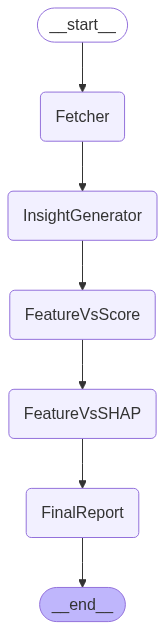

In [43]:
# Optional: Visualize LangGraph structure
display(Image(graph.get_graph().draw_mermaid_png()))

In [44]:
# ================================
# 🚀 Run for Multiple Customers
# ================================
def analyze_batch(customer_ids: List[str]):
    display(Markdown("## 📊 **Batch Customer Insight Reports**\n---"))
    for cid in customer_ids:
        initial_state = {
            "customer_id": cid,
            "customer_data": {},
            "insights": "",
            "image_summaries": []
        }
        _ = graph.invoke(initial_state)


In [45]:
# Example batch run
batch_ids = [f"CUST_{i:03d}" for i in range(2)]
analyze_batch(batch_ids)

## 📊 **Batch Customer Insight Reports**
---


---
### 🧾 **Customer Insight Report**
- **Customer ID:** `CUST_000`

**Insights:**
**Customer Experience Analysis for CUST_000**

Based on the provided KPI values, SHAP values, and scores, I will provide a detailed analysis of the factors contributing to the customer's experience score.

**Overall Experience Score: 4.37**

The customer's overall experience score is 4.37 out of 10, indicating a relatively low satisfaction level. This score is influenced by the subscores, particularly the Signal Quality subscore.

**Signal Quality Subscore: 9.56**

The Signal Quality subscore is 9.56 out of 10, which is surprisingly high considering the overall experience score. This suggests that the customer is experiencing good signal quality, but there are other factors contributing to the low overall experience score.

**KPI Values:**

- **Reference Signal Received Power (RSRP): 43.2**
- **Signal to Interference plus Noise Ratio (SINR): 52.32**

The RSRP value of 43.2 is relatively low, indicating that the customer is experiencing weak signal strength. However, the SINR value of 52.32 is high, suggesting that the signal is strong and not significantly affected by interference or noise.

**SHAP Values:**

- **RSRP SHAP Value: 2.93**
- **SINR SHAP Value: -7.14**

The SHAP values provide insight into the relative importance of each KPI value in contributing to the overall experience score. The RSRP SHAP value of 2.93 indicates that the weak signal strength is a significant contributor to the low overall experience score. On the other hand, the SINR SHAP value of -7.14 suggests that the high SINR value is actually a negative contributor to the overall experience score, which seems counterintuitive.

**Analysis and Recommendations:**

Based on the analysis, the customer's experience score is low due to the weak signal strength (RSRP value of 43.2). However, the high SINR value suggests that the signal is strong and not significantly affected by interference or noise. The discrepancy between the SHAP values and KPI values is puzzling, as the SHAP values suggest that the high SINR value is a negative contributor to the overall experience score.

To improve the customer's experience score, we recommend addressing the weak signal strength by optimizing the network infrastructure or adjusting the customer's device settings. Additionally, we need to investigate the reason behind the negative contribution of the high SINR value to the overall experience score, as it seems counterintuitive.

**Action Items:**

1. Investigate the reason behind the negative contribution of the high SINR value to the overall experience score.
2. Optimize the network infrastructure to improve signal strength for the customer.
3. Adjust the customer's device settings to optimize signal reception.

By addressing these issues, we can improve the customer's experience score and provide a better overall experience.

### Visual Summary Insights
📊 `rsrp` vs `main_score`: Based on the provided data sample, it appears that the feature 'rsrp' shows a generally increasing pattern across the score deciles. 

Looking at the data, we can see that as the 'main_score' increases from 1 to 10, the 'rsrp' values also tend to increase. For example, when the 'main_score' is between 1 and 2, the 'rsrp' values are relatively low (around 40-50). However, as the 'main_score' increases to 4-6, the 'rsrp' values also increase to around 50-60. 

Furthermore, when the 'main_score' is higher (7-10), the 'rsrp' values tend to be even higher (around 60-70). This suggests a positive correlation between 'rsrp' and 'main_score', indicating that better signal quality (higher 'rsrp') is associated with higher overall experience scores.

This relationship implies that the 'rsrp' feature is an important factor in determining the overall experience score, and that improving signal quality can lead to better customer experience.<br>📊 `sinr` vs `main_score`: Analyzing the relationship between the feature 'sinr' and the main score 'main_score', which has been divided into deciles (1–10), we can observe the following pattern:

- The highest 'sinr' values (above 60) are associated with the highest 'main_score' deciles (8-10).
- The lowest 'sinr' values (below 40) are associated with the lowest 'main_score' deciles (1-3).
- There is a general increasing trend in 'sinr' values as we move from lower to higher 'main_score' deciles.

This implies that the feature 'sinr' shows a positive relationship with the main score 'main_score'. In other words, as the Signal to Interference plus Noise Ratio (sinr) increases, the overall experience score (main_score) also tends to increase. This suggests that signal quality is an important factor in determining the overall customer experience.

However, it's worth noting that there are some exceptions and outliers in the data, such as the point with 'sinr' = 88.53 and 'main_score' = 6.33, which does not follow the general trend. Nevertheless, the overall pattern suggests a positive relationship between 'sinr' and 'main_score'.<br>🔬 `rsrp` vs `shap_rsrp`: Analyzing the relationship between 'rsrp' and its SHAP value 'shap_rsrp' in the given data, we can observe the following:

- When 'rsrp' is high (e.g., 68.66, 73.15), 'shap_rsrp' is low or negative (e.g., -11.91, 6.86). This suggests that high 'rsrp' values are associated with lower SHAP values, implying that the model does not strongly rely on 'rsrp' when the signal quality is already good.
- When 'rsrp' is low (e.g., 40.25, 36.22), 'shap_rsrp' is high or positive (e.g., 11.59, 5.15). This indicates that low 'rsrp' values are associated with higher SHAP values, suggesting that the model places more importance on 'rsrp' when the signal quality is poor.
- There are instances where 'rsrp' is moderate (e.g., 43.20, 47.77), and 'shap_rsrp' is also moderate (e.g., 2.93, 4.73). This implies that the model's reliance on 'rsrp' is balanced when the signal quality is average.

Overall, the SHAP values suggest that the model prioritizes 'rsrp' when the signal quality is poor but reduces its importance when the signal quality is already good. This implies that the model is trying to balance the trade-off between signal quality and other factors that contribute to the overall experience score.<br>🔬 `sinr` vs `shap_sinr`: Analyzing the relationship between the feature 'sinr' and its SHAP value 'shap_sinr' in the given data, we can observe the following:

- When 'sinr' is high (above 50), 'shap_sinr' tends to be positive, indicating that the model interprets higher 'sinr' values as contributing positively to the overall experience score.
- When 'sinr' is low (below 50), 'shap_sinr' tends to be negative, indicating that the model interprets lower 'sinr' values as contributing negatively to the overall experience score.

This implies that the model is using 'sinr' as a feature to predict the overall experience score, and it is interpreting higher 'sinr' values as a positive indicator of a good experience. Conversely, lower 'sinr' values are seen as a negative indicator.

However, there are some instances where 'sinr' is high but 'shap_sinr' is negative, and vice versa. This could indicate that the model is also considering other factors or interactions when making its predictions, and 'sinr' is not the only feature influencing the outcome.

Overall, the positive correlation between 'sinr' and 'shap_sinr' suggests that the model is using 'sinr' as a feature to predict a better overall experience score when the signal-to-interference ratio is high.
---



---
### 🧾 **Customer Insight Report**
- **Customer ID:** `CUST_001`

**Insights:**
**Customer Experience Analysis Report for CUST_001**

**Summary:**

Based on the provided KPI values, SHAP values, and scores, we can analyze the factors contributing to the customer's experience score. The overall experience score for CUST_001 is 7.59 out of 10, with a signal quality subscore of 6.39 out of 10.

**Signal Quality Subscore:**

The signal quality subscore is 6.39, which indicates that the customer is experiencing some issues with signal strength. The SHAP value for Reference Signal Received Power (RSRP) is -11.91, which suggests that the low RSRP value is significantly impacting the signal quality subscore. RSRP measures the strength of the signal received by the customer's device, and a lower value indicates a weaker signal. This is likely the primary factor contributing to the low signal quality subscore.

**Overall Experience Score:**

The overall experience score is 7.59, which is relatively high. However, it's lower than expected given the signal quality subscore. The SHAP value for Signal to Interference plus Noise Ratio (SINR) is 6.57, which suggests that the SINR value is positively impacting the overall experience score. SINR measures the quality of the signal relative to interference and noise, and a higher value indicates better signal quality. This discrepancy between the SHAP values and the overall experience score may indicate that other factors, not captured by the SHAP values, are contributing to the overall experience score.

**KPI Values:**

The KPI values for RSRP and SINR are 68.66 and 54.74, respectively. While the RSRP value is relatively low, the SINR value is moderate. The SHAP values suggest that the RSRP value is negatively impacting the signal quality subscore, but the overall experience score is not as low as expected. This discrepancy may indicate that the customer is experiencing some benefits from the moderate SINR value that are not captured by the SHAP values.

**Key Takeaways:**

1. The low signal quality subscore is primarily due to the low RSRP value.
2. The overall experience score is higher than expected, suggesting that other factors, not captured by the SHAP values, are contributing to the score.
3. The moderate SINR value is positively impacting the overall experience score, but the SHAP values do not fully capture this impact.

**Recommendations:**

1. Investigate the root cause of the low RSRP value to improve signal strength for CUST_001.
2. Consider incorporating additional factors into the SHAP values to better capture the impact of SINR on the overall experience score.
3. Analyze the customer's behavior and preferences to identify other factors that may be contributing to the overall experience score.

### Visual Summary Insights
📊 `rsrp` vs `main_score`: Based on the provided data sample, it appears that the feature 'rsrp' shows a generally increasing pattern across the score deciles. 

Looking at the data, we can see that as the 'main_score' increases from 1 to 10, the 'rsrp' values also tend to increase. For example, when the 'main_score' is between 1 and 2, the 'rsrp' values are relatively low (around 40-50). However, as the 'main_score' increases to 4-6, the 'rsrp' values also increase to around 50-60. 

Furthermore, when the 'main_score' is higher (7-10), the 'rsrp' values tend to be even higher (around 60-70). This suggests a positive correlation between 'rsrp' and 'main_score', indicating that better signal quality (higher 'rsrp') is associated with higher overall experience scores.

This relationship implies that the 'rsrp' feature is an important factor in determining the overall experience score, and that improving signal quality can lead to better customer experience.<br>📊 `sinr` vs `main_score`: Analyzing the relationship between the feature 'sinr' and the main score 'main_score', which has been divided into deciles (1–10), we can observe the following pattern:

- The highest 'sinr' values (above 60) are associated with the highest 'main_score' deciles (8-10).
- The lowest 'sinr' values (below 40) are associated with the lowest 'main_score' deciles (1-3).
- There is a general increasing trend in 'sinr' values as we move from lower to higher 'main_score' deciles.

This implies that the feature 'sinr' shows a positive relationship with the main score 'main_score'. In other words, as the Signal to Interference plus Noise Ratio (sinr) increases, the overall experience score (main_score) also tends to increase. This suggests that signal quality is an important factor in determining the overall customer experience.

However, it's worth noting that there are some exceptions and outliers in the data, such as the point with 'sinr' = 88.53 and 'main_score' = 6.33, which does not follow the general trend. Nevertheless, the overall pattern suggests a positive relationship between 'sinr' and 'main_score'.<br>🔬 `rsrp` vs `shap_rsrp`: Analyzing the relationship between 'rsrp' and its SHAP value 'shap_rsrp' in the given data, we can observe the following:

- When 'rsrp' is high (e.g., 68.66, 73.15), 'shap_rsrp' is low or negative (e.g., -11.91, 6.86). This suggests that high 'rsrp' values are associated with lower SHAP values, implying that the model does not strongly rely on 'rsrp' when the signal quality is already good.
- When 'rsrp' is low (e.g., 40.25, 36.22), 'shap_rsrp' is high or positive (e.g., 11.59, 5.15). This indicates that low 'rsrp' values are associated with higher SHAP values, suggesting that the model places more importance on 'rsrp' when the signal quality is poor.
- There are instances where 'rsrp' is moderate (e.g., 43.20, 47.77), and 'shap_rsrp' is also moderate (e.g., 2.93, 4.73). This implies that the model's reliance on 'rsrp' is balanced when the signal quality is average.

Overall, the SHAP values suggest that the model prioritizes 'rsrp' when the signal quality is poor but does not heavily rely on it when the signal quality is already good. This implies that the model is able to adapt to different signal conditions and adjust its reliance on 'rsrp' accordingly.<br>🔬 `sinr` vs `shap_sinr`: Analyzing the relationship between the feature 'sinr' and its SHAP value 'shap_sinr' in the given data, we can observe the following:

- When 'sinr' is high (above 50), 'shap_sinr' tends to be positive, indicating that the model interprets higher 'sinr' values as contributing positively to the overall experience score.
- When 'sinr' is low (below 50), 'shap_sinr' tends to be negative, indicating that the model interprets lower 'sinr' values as contributing negatively to the overall experience score.

This implies that the model is using 'sinr' as a feature to predict the overall experience score, and it is interpreting higher 'sinr' values as a positive indicator of a good experience. Conversely, lower 'sinr' values are seen as a negative indicator.

However, there are some instances where 'sinr' is high but 'shap_sinr' is negative, and vice versa. This could indicate that the model is also considering other factors or interactions when making its predictions, and 'sinr' is not the only feature influencing the outcome.

Overall, the positive correlation between 'sinr' and 'shap_sinr' suggests that the model is using 'sinr' as a feature to predict a better overall experience score when the signal-to-interference ratio is high.
---
